In [1]:
# !pip3 uninstall --yes torch torchaudio torchvision torchtext torchdata --quiet
# !pip3 install torch torchaudio torchvision torchtext torchdata --quiet
# !pip install torchdiffeq --quiet

In [3]:
import torch
from torch import nn, optim, Tensor, tensor
import torchdiffeq as tdf
import matplotlib.pyplot as plt
import numpy as np
import progressbar
from IPython.display import clear_output

In [4]:
# device = "cuda" if torch.cuda.is_available() else "cpu"
device = 'cpu'
seed = 2024
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)

## Logistic Function
> The dynamical equation we want to learn is:

$$
\dot{y} = r\left(1-\frac{y}{K}\right)y
$$
where:
- $y$ is the population size.
- $r$ is the growth rate.
- $K$ is the capacity of environment.

## ODEFunc
> The MLP consists of 3 layer, each activation function is `Tanh()`,





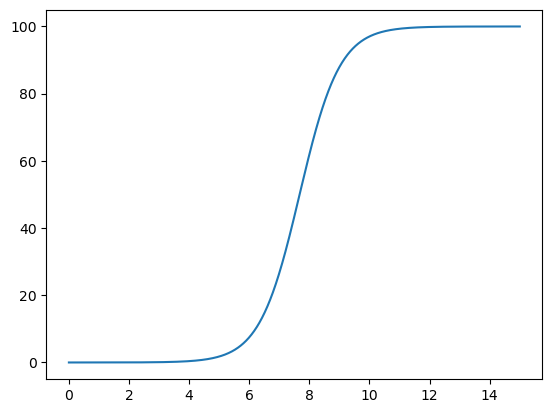

In [5]:
t = torch.linspace(0,15,1500).to(device)

class growth_model(nn.Module):
  def __init__(self, *args):
    super(growth_model, self).__init__()
    self.K, self.r = args

  def forward(self, t, y):
    return self.r * y * (1 - y/self.K)


true_y0 = torch.Tensor([0.001]).to(device)
true_model = growth_model(100, 1.5).to(device)
with torch.no_grad():
  true_y = tdf.odeint(true_model, true_y0, t)

class ODEFunc(nn.Module):
  def __init__(self):
    super(ODEFunc, self).__init__()
    self.net = nn.Sequential(
        nn.Linear(1,50),
        nn.Tanh(),
        nn.Linear(50,50),
        nn.Tanh(),
        nn.Linear(50,1)
    )
    for m in self.net.modules():
      if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, 0, 1)
        nn.init.constant_(m.bias, 0)

  def forward(self, t, y):
    return self.net(y)



def get_batch(batch_time, batch_num,total_time=len(t)):
  s = torch.from_numpy(np.random.choice(np.arange(total_time - batch_time), batch_num, replace=False))
  batch_t = t[:batch_time]
  batch_y0 = true_y[s]
  batch_y = torch.stack([true_y[s+i] for i in range(batch_time)], dim=0)

  return batch_t.to(device), batch_y0.to(device), batch_y.to(device)

  # batch_y0 =

plt.plot(t.cpu(), true_y.cpu())

# np.choice(np.arange(1000), )

In [4]:
func = ODEFunc().to(device)

def train_epoch(max_epoch, func,lr):
  optimizer = optim.Adam(func.parameters(), lr=lr)
  loss_list = []
  
  for epoch in progressbar.progressbar(range(max_epoch), redirect_stdout=True):
    optimizer.zero_grad()
    batch_t, batch_y0, batch_y = get_batch(20, 100)
    pred_y = tdf.odeint_adjoint(func, batch_y0, batch_t)
    loss = torch.mean(torch.abs(pred_y - batch_y))
    loss.backward()
    optimizer.step()
    # bar.update(epoch)

    if epoch % 100 == 0:
    # # loss_list.append(loss.item())
      print('epoch=',epoch,'\t',loss.item())


  return loss_list

  # tdf.odeint_adjoint(func,get_batch(20, 100)[1], t)

# loss_list = train_epoch(1000)

In [5]:
l1 = train_epoch(1500,func, 1e-2)
l2 = train_epoch(1500,func, 1e-3)
l3 = train_epoch(1500,func, 1e-5)
l4 = train_epoch(1500,func, 1e-7)

  0% (0 of 1500) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--

epoch= 0 	 0.8322097659111023


  6% (100 of 1500) |#                    | Elapsed Time: 0:00:41 ETA:   0:09:36

epoch= 100 	 0.5641283392906189


 13% (200 of 1500) |##                   | Elapsed Time: 0:01:34 ETA:   0:10:12

epoch= 200 	 0.40663623809814453


 20% (300 of 1500) |####                 | Elapsed Time: 0:02:35 ETA:   0:10:23

epoch= 300 	 0.31199541687965393


 26% (400 of 1500) |#####                | Elapsed Time: 0:03:51 ETA:   0:10:37

epoch= 400 	 0.22934238612651825


 33% (500 of 1500) |#######              | Elapsed Time: 0:05:01 ETA:   0:10:03

epoch= 500 	 0.17589928209781647


 40% (600 of 1500) |########             | Elapsed Time: 0:06:21 ETA:   0:09:32

epoch= 600 	 0.07670974731445312


 46% (700 of 1500) |#########            | Elapsed Time: 0:07:38 ETA:   0:08:43

epoch= 700 	 0.31731557846069336


 53% (800 of 1500) |###########          | Elapsed Time: 0:08:59 ETA:   0:07:51

epoch= 800 	 0.18358798325061798


 60% (900 of 1500) |############         | Elapsed Time: 0:10:19 ETA:   0:06:53

epoch= 900 	 0.1807364523410797


 66% (1000 of 1500) |#############       | Elapsed Time: 0:11:23 ETA:   0:05:41

epoch= 1000 	 0.24680660665035248


 73% (1100 of 1500) |##############      | Elapsed Time: 0:11:54 ETA:   0:04:19

epoch= 1100 	 0.10123871266841888


 80% (1200 of 1500) |################    | Elapsed Time: 0:12:26 ETA:   0:03:06

epoch= 1200 	 0.07660622894763947


 86% (1300 of 1500) |#################   | Elapsed Time: 0:12:58 ETA:   0:01:59

epoch= 1300 	 0.09781389683485031


 93% (1400 of 1500) |##################  | Elapsed Time: 0:13:29 ETA:   0:00:5711

epoch= 1400 	 0.11645469069480896


100% (1500 of 1500) |####################| Elapsed Time: 0:14:00 Time:  0:14:0007
  0% (0 of 1500) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--

epoch= 0 	 0.09130502492189407


  6% (100 of 1500) |#                    | Elapsed Time: 0:00:28 ETA:   0:06:37

epoch= 100 	 0.02816120907664299


 13% (200 of 1500) |##                   | Elapsed Time: 0:00:56 ETA:   0:06:09

epoch= 200 	 0.019473813474178314


 20% (300 of 1500) |####                 | Elapsed Time: 0:01:25 ETA:   0:05:41

epoch= 300 	 0.014661337248980999


 26% (400 of 1500) |#####                | Elapsed Time: 0:01:53 ETA:   0:05:12

epoch= 400 	 0.027113404124975204


 33% (500 of 1500) |#######              | Elapsed Time: 0:02:22 ETA:   0:04:45

epoch= 500 	 0.01131935603916645


 40% (600 of 1500) |########             | Elapsed Time: 0:02:51 ETA:   0:04:17

epoch= 600 	 0.00894320197403431


 46% (700 of 1500) |#########            | Elapsed Time: 0:03:20 ETA:   0:03:48

epoch= 700 	 0.028327390551567078


 53% (800 of 1500) |###########          | Elapsed Time: 0:03:47 ETA:   0:03:19

epoch= 800 	 0.013715466484427452


 60% (900 of 1500) |############         | Elapsed Time: 0:04:17 ETA:   0:02:51

epoch= 900 	 0.009315947070717812


 66% (1000 of 1500) |#############       | Elapsed Time: 0:04:45 ETA:   0:02:22

epoch= 1000 	 0.021698009222745895


 73% (1100 of 1500) |##############      | Elapsed Time: 0:05:15 ETA:   0:01:54

epoch= 1100 	 0.011427035555243492


 80% (1200 of 1500) |################    | Elapsed Time: 0:05:44 ETA:   0:01:26

epoch= 1200 	 0.011627738364040852


 86% (1300 of 1500) |#################   | Elapsed Time: 0:06:13 ETA:   0:00:57

epoch= 1300 	 0.012468214146792889


 93% (1400 of 1500) |##################  | Elapsed Time: 0:06:41 ETA:   0:00:2835

epoch= 1400 	 0.012990711256861687


100% (1500 of 1500) |####################| Elapsed Time: 0:07:10 Time:  0:07:1003
  0% (0 of 1500) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--

epoch= 0 	 0.012899373658001423


  6% (100 of 1500) |#                    | Elapsed Time: 0:00:27 ETA:   0:06:29

epoch= 100 	 0.00842258706688881


 13% (200 of 1500) |##                   | Elapsed Time: 0:00:54 ETA:   0:05:56

epoch= 200 	 0.008910296484827995


 20% (300 of 1500) |####                 | Elapsed Time: 0:01:23 ETA:   0:05:33

epoch= 300 	 0.007367424201220274


 26% (400 of 1500) |#####                | Elapsed Time: 0:01:52 ETA:   0:05:08

epoch= 400 	 0.008590087294578552


 33% (500 of 1500) |#######              | Elapsed Time: 0:02:21 ETA:   0:04:42

epoch= 500 	 0.008437516167759895


 40% (600 of 1500) |########             | Elapsed Time: 0:02:50 ETA:   0:04:15

epoch= 600 	 0.008172295056283474


 46% (700 of 1500) |#########            | Elapsed Time: 0:03:19 ETA:   0:03:47

epoch= 700 	 0.006293375976383686


 53% (800 of 1500) |###########          | Elapsed Time: 0:03:47 ETA:   0:03:19

epoch= 800 	 0.004494260065257549


 60% (900 of 1500) |############         | Elapsed Time: 0:04:17 ETA:   0:02:51

epoch= 900 	 0.006214088294655085


 66% (1000 of 1500) |#############       | Elapsed Time: 0:04:46 ETA:   0:02:23

epoch= 1000 	 0.007591139059513807


 73% (1100 of 1500) |##############      | Elapsed Time: 0:05:13 ETA:   0:01:53

epoch= 1100 	 0.007752414792776108


 80% (1200 of 1500) |################    | Elapsed Time: 0:05:40 ETA:   0:01:25

epoch= 1200 	 0.006227972451597452


 86% (1300 of 1500) |#################   | Elapsed Time: 0:06:09 ETA:   0:00:56

epoch= 1300 	 0.007906858809292316


 93% (1400 of 1500) |##################  | Elapsed Time: 0:06:37 ETA:   0:00:2834

epoch= 1400 	 0.007837356999516487


100% (1500 of 1500) |####################| Elapsed Time: 0:07:05 Time:  0:07:0503
  0% (0 of 1500) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--

epoch= 0 	 0.008307574316859245


  6% (100 of 1500) |#                    | Elapsed Time: 0:00:28 ETA:   0:06:42

epoch= 100 	 0.009241241961717606


 13% (200 of 1500) |##                   | Elapsed Time: 0:00:57 ETA:   0:06:11

epoch= 200 	 0.007151884958148003


 20% (300 of 1500) |####                 | Elapsed Time: 0:01:25 ETA:   0:05:43

epoch= 300 	 0.007746253628283739


 26% (400 of 1500) |#####                | Elapsed Time: 0:01:54 ETA:   0:05:15

epoch= 400 	 0.007275786250829697


 33% (500 of 1500) |#######              | Elapsed Time: 0:02:22 ETA:   0:04:44

epoch= 500 	 0.007775722537189722


 40% (600 of 1500) |########             | Elapsed Time: 0:02:51 ETA:   0:04:17

epoch= 600 	 0.009979918599128723


 46% (700 of 1500) |#########            | Elapsed Time: 0:03:19 ETA:   0:03:47

epoch= 700 	 0.006378833670169115


 53% (800 of 1500) |###########          | Elapsed Time: 0:03:47 ETA:   0:03:18

epoch= 800 	 0.009980371221899986


 60% (900 of 1500) |############         | Elapsed Time: 0:04:16 ETA:   0:02:50

epoch= 900 	 0.008358994498848915


 66% (1000 of 1500) |#############       | Elapsed Time: 0:04:44 ETA:   0:02:22

epoch= 1000 	 0.00655066454783082


 73% (1100 of 1500) |##############      | Elapsed Time: 0:05:13 ETA:   0:01:54

epoch= 1100 	 0.009302664548158646


 80% (1200 of 1500) |################    | Elapsed Time: 0:05:42 ETA:   0:01:25

epoch= 1200 	 0.006765901576727629


 86% (1300 of 1500) |#################   | Elapsed Time: 0:06:11 ETA:   0:00:57

epoch= 1300 	 0.005937749054282904


 93% (1400 of 1500) |##################  | Elapsed Time: 0:06:40 ETA:   0:00:2835

epoch= 1400 	 0.005831090267747641


100% (1500 of 1500) |####################| Elapsed Time: 0:07:09 Time:  0:07:0903


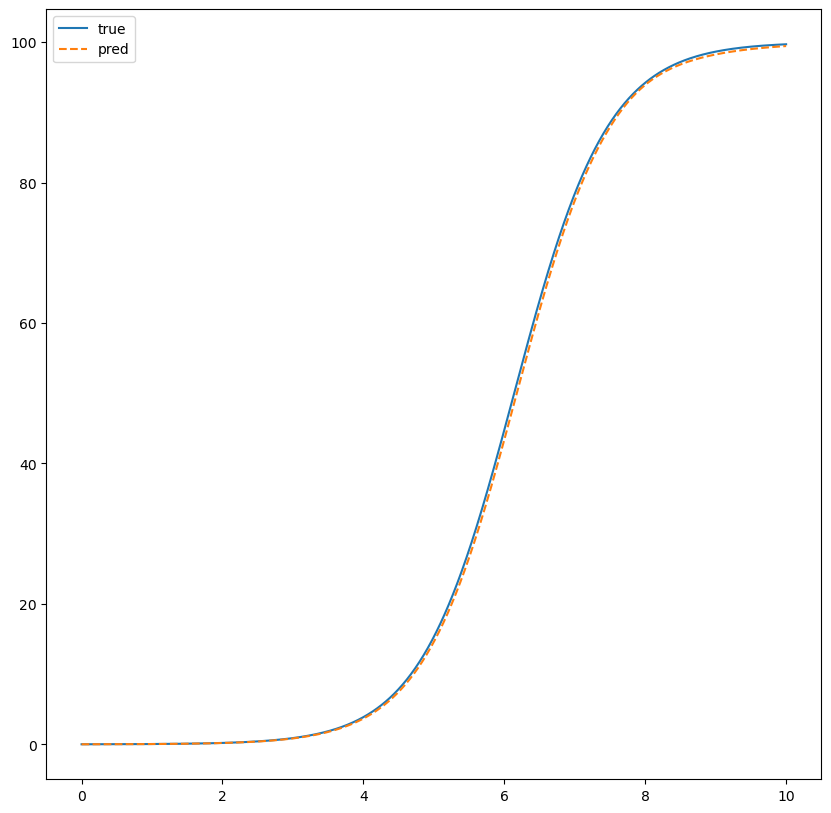

In [8]:
fig = plt.figure(figsize=(10,10))
t2 = torch.linspace(0,10,1000).to(device)
ax = fig.add_subplot(111)
true_y02 = torch.Tensor([0.01]).to(device)
with torch.no_grad():
  y_true = tdf.odeint(true_model, true_y02, t2)
  y_pred = tdf.odeint(func, true_y02, t2)
ax.plot(t2.cpu(), y_true.cpu(), label="true")
ax.plot(t2.cpu(), y_pred.detach().numpy(), label="pred", linestyle='--')
ax.legend()

In [9]:
torch.save(func.state_dict(), './logODE.pt')

In [8]:
t_model = ODEFunc()
t_model.load_state_dict(torch.load('./logODE.pt'))
t_model.eval

<bound method Module.eval of ODEFunc(
  (net): Sequential(
    (0): Linear(in_features=1, out_features=50, bias=True)
    (1): Tanh()
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Tanh()
    (4): Linear(in_features=50, out_features=1, bias=True)
  )
)>

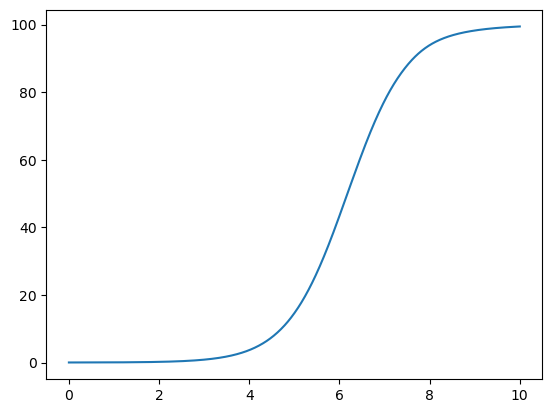

In [14]:
tt = torch.linspace(0,10,1000).to(device)
true_y0 = torch.Tensor([0.01]).to(device)
y_pred = tdf.odeint(t_model, true_y0, tt)
plt.plot(tt, y_pred.detach().numpy())